In [1]:
#Import Python Libraries

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [2]:
## Data Preparation and KNN modeling

diabetes = pd.read_csv("https://datahub.io/machine-learning/diabetes/r/diabetes.csv")
X = diabetes.drop('class', axis=1)
y = diabetes['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(f"Accuracy: {round(metrics.accuracy_score(y_test, y_pred)*100, 2)}%")
df_confusion = pd.crosstab(y_test, y_pred)
df_confusion

Accuracy: 72.29%


col_0,tested_negative,tested_positive
class,,
tested_negative,124,23
tested_positive,41,43


In [3]:
## Preprocess Data: Standardization/Normalization

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
pd.DataFrame(X_train_std).mean()
X_train_std.std()
X_train.mean()
X_train.std()

preg      3.309324
plas     32.972357
pres     19.563244
skin     16.123755
insu    115.457871
mass      8.165811
pedi      0.332525
age      11.459534
dtype: float64

In [4]:
## KNN Performance Evaluation

classifier_std = KNeighborsClassifier()
classifier_std.fit(X_train_std, y_train)
y_pred_std = classifier_std.predict(X_test_std)
pd.Series(y_pred_std).value_counts()
value, count = np.unique(y_pred_std, return_counts=True)
pd.DataFrame({"value": value, "count": count})
print(f"Accuracy: {round(metrics.accuracy_score(y_test, y_pred_std)*100, 2)}%")

Accuracy: 74.89%


In [5]:
## Use Pipeline to Streamline the Analysis

knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())
knn_pipe.fit(X_train, y_train)
pipe_pred = knn_pipe.predict(X_test)
pd.Series(pipe_pred).value_counts()

tested_negative    165
tested_positive     66
dtype: int64

In [6]:
## Get Repeated Hold Out Accurary of Model

cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=16)
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, shuffle=True, random_state=16)
cross_val_score(knn_pipe, X_train, y_train, cv=cv).mean()

0.7022361984626136

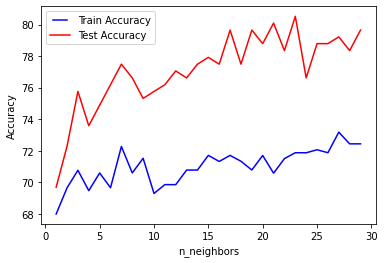

In [7]:
## Sensitivity Analysis

from matplotlib.legend_handler import HandlerLine2D
neighbors = list(range(1, 30))
train_results = []
test_results = []
for n in neighbors:
  model = KNeighborsClassifier(n_neighbors=n)
  model.fit(X_train_std, y_train)
  train_pred = model.predict(X_train_std)
  acc = cross_val_score(model, X_train_std, y_train, cv=cv).mean()*100
  train_results.append(acc)
  y_pred = model.predict(X_test_std)
  acc_test = round(metrics.accuracy_score(y_test, y_pred)*100, 2)
  test_results.append(acc_test)

line1, = plt.plot(neighbors, train_results, 'b', label="Train Accuracy")
line2, = plt.plot(neighbors, test_results, 'r', label="Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.show()

In [8]:
## Ensemble Learning - Bagging

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

cart = DecisionTreeClassifier()
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=16)
results = cross_val_score(model, X_train_std, y_train, cv=cv)
print(f"Accuracy: {round(results.mean()*100, 2)}%")

Accuracy: 73.03%


In [9]:
## Random Forest

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=num_trees, max_features=5, random_state=16)
results = cross_val_score(model, X_train_std, y_train, cv=cv)
print(f"Accuracy: {round(results.mean()*100, 2)}%")
model

Accuracy: 73.59%


RandomForestClassifier(max_features=5, random_state=16)

In [10]:
## Feature Importance

model.fit(X_train_std, y_train)
feature_imp = pd.DataFrame(model.feature_importances_, index=X_train.columns,
columns=['importance']).sort_values('importance', ascending=False)
feature_imp

,importance
plas,0.299555
mass,0.192756
pedi,0.133711
age,0.105525
pres,0.083997
preg,0.067676
insu,0.059420
skin,0.057359


In [11]:
## AdaBoosting

from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=num_trees, random_state=16)
results = cross_val_score(model, X_train_std, y_train, cv=cv)
print(f"Accuracy: {round(results.mean()*100, 2)}%")
model

Accuracy: 72.08%


AdaBoostClassifier(n_estimators=100, random_state=16)

In [12]:
## GBM

from sklearn.ensemble import GradientBoostingClassifier as gbm
model = gbm(n_estimators=num_trees, random_state=16)
results = cross_val_score(model, X_train_std, y_train, cv=cv)
print(f"Accuracy for GBM: {round(results.mean()*100, 2)}%")
model

Accuracy for GBM: 72.47%


GradientBoostingClassifier(random_state=16)

In [13]:
## Model Tuning

from sklearn.model_selection import GridSearchCV
param_grid = {'learning_rate': np.arange(0.02, 0.1, 0.02),
              'n_estimators': range(60, 160, 50),
              'max_depth': range(2, 5)}
clf = GridSearchCV(gbm(), param_grid)
clf.fit(X_train_std, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': array([0.02, 0.04, 0.06, 0.08]),
                         'max_depth': range(2, 5),
                         'n_estimators': range(60, 160, 50)})

In [14]:
## Model Tuning (2)

print(f"Accuracy for best GBM: {round(clf.best_score_*100, 2)}%")
for key, val in clf.best_params_.items():
  print(f"Best hyperparameter is {key}: {val}")

Accuracy for best GBM: 77.11%
Best hyperparameter is learning_rate: 0.08
Best hyperparameter is max_depth: 2
Best hyperparameter is n_estimators: 60
